In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("../data/AML-World/HI-Small_Trans.csv")

In [4]:
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


In [5]:
df['Sender_account'] = df['From Bank'].astype(str) + df['Account'].astype(str)
df['Receiver_account'] = df['To Bank'].astype(str) + df['Account.1'].astype(str)

In [6]:
# Create a unified set of customer IDs
accounts = pd.concat([df['Sender_account'], df['Receiver_account']]).unique()
customer_ids = {account: i for i, account in enumerate(accounts, 1)}

# Map both sender and receiver accounts to the same customer ID
df['Sender_customer_id'] = df['Sender_account'].map(customer_ids)
df['Receiver_customer_id'] = df['Receiver_account'].map(customer_ids)

# Now we need to reshape the dataframe to compute aggregates
# Concatenate the data to treat sends and receives the same
senders = df[['Sender_customer_id', 'Amount Paid', 'Payment Currency', 'Payment Format', 'Is Laundering']].rename(columns={
    'Sender_customer_id': 'Customer_ID',
    'Amount Paid': 'Amount',
    'Payment Currency': 'Currency',
    'Payment Format': 'Format',
    'Is Laundering': 'Is_laundering'
})
receivers = df[['Receiver_customer_id', 'Amount Received', 'Receiving Currency', 'Payment Format', 'Is Laundering']].rename(columns={
    'Receiver_customer_id': 'Customer_ID',
    'Amount Received': 'Amount',
    'Receiving Currency': 'Currency',
    'Payment Format': 'Format',
    'Is Laundering': 'Is_laundering'
})

# Combine both sending and receiving into one DataFrame
combined_df = pd.concat([senders, receivers])

# Aggregate by customer ID
customer_features = combined_df.groupby('Customer_ID').agg(
    total_amount=('Amount', 'sum'),
    transaction_count=('Amount', 'count'),
    average_amount=('Amount', 'mean'),
    max_amount=('Amount', 'max'),
    min_amount=('Amount', 'min'),
    unique_currencies=('Currency', pd.Series.nunique),
    unique_locations=('Format', pd.Series.nunique),
    is_laundering=('Is_laundering', 'max')  # Assuming any true value indicates potential laundering
).reset_index()


In [ ]:
customer_features

,Customer_ID,total_amount,transaction_count,average_amount,max_amount,min_amount,unique_currencies,unique_locations,is_laundering
0,1,15801400.91,80,197517.511375,7495533.00,0.27,4,6,0
1,2,3717.92,2,1858.960000,1858.96,1858.96,1,1,0
2,3,24.64,2,12.320000,12.32,12.32,1,1,0
3,4,13148.00,70,187.828571,2941.56,0.50,1,3,0
4,5,4456776.38,41,108701.862927,2108643.71,1.14,2,5,0
...,...,...,...,...,...,...,...,...,...
705902,705903,26269.09,1,26269.090000,26269.09,26269.09,1,1,0
705903,705904,1502.09,1,1502.090000,1502.09,1502.09,1,1,0
705904,705905,8759.34,5,1751.868000,3626.84,64.24,1,1,0
705905,705906,6634.08,1,6634.080000,6634.08,6634.08,1,1,0


# building dataset

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler

# Assuming 'customer_features' is already created and contains the necessary features

# Features and Labels
X = customer_features.drop('is_laundering', axis=1)
y = customer_features['is_laundering']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Linear regression

In [ ]:


# Create a logistic regression model
model = LogisticRegression()

# Train the model
model.fit(X_train_scaled, y_train)

# Predictions
predictions = model.predict(X_test_scaled)
probabilities = model.predict_proba(X_test_scaled)[:, 1]  # Probabilities needed for AUC

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))
print("\nClassification Report:")
print(classification_report(y_test, predictions))

# Additional Metrics
auc_score = roc_auc_score(y_test, probabilities)
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)

print(f"AUC: {auc_score:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")


Confusion Matrix:
[[210181      0]
 [  1588      4]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    210181
           1       1.00      0.00      0.01      1592

    accuracy                           0.99    211773
   macro avg       1.00      0.50      0.50    211773
weighted avg       0.99      0.99      0.99    211773

AUC: 0.72
Accuracy: 0.99
F1 Score: 0.01
Precision: 1.00
Recall: 0.00


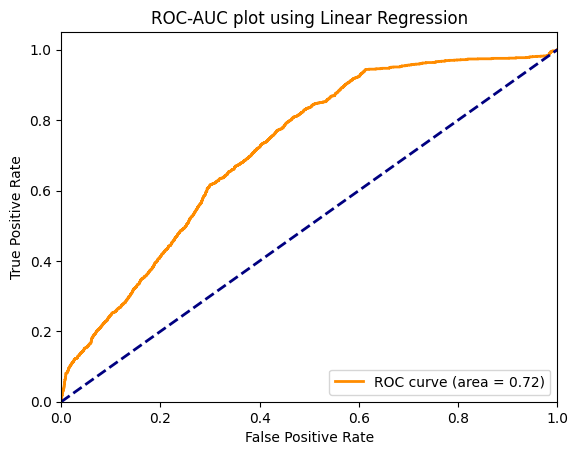

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)

# Plotting ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC plot using Linear Regression')
plt.legend(loc="lower right")
plt.show()

# decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Create a logistic regression model
model = DecisionTreeClassifier()

# Train the model
model.fit(X_train_scaled, y_train)

# Predictions
predictions = model.predict(X_test_scaled)
probabilities = model.predict_proba(X_test_scaled)[:, 1]  # Probabilities needed for AUC

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))
print("\nClassification Report:")
print(classification_report(y_test, predictions))

# Additional Metrics
auc_score = roc_auc_score(y_test, probabilities)
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)

print(f"AUC: {auc_score:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")


Confusion Matrix:
[[208395   1786]
 [  1516     76]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    210181
           1       0.04      0.05      0.04      1592

    accuracy                           0.98    211773
   macro avg       0.52      0.52      0.52    211773
weighted avg       0.99      0.98      0.99    211773

AUC: 0.52
Accuracy: 0.98
F1 Score: 0.04
Precision: 0.04
Recall: 0.05


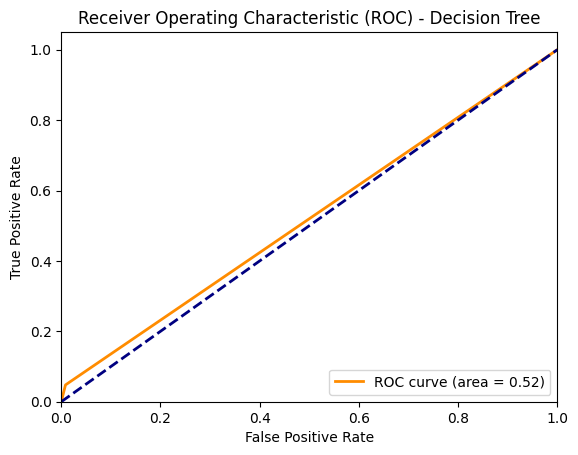

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)

# Plotting ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Decision Tree')
plt.legend(loc="lower right")
plt.show()

# xgboost

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier(random_state=42)

# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions
predictions = model.predict(X_test_scaled)
probabilities = model.predict_proba(X_test_scaled)[:, 1]  # Probabilities needed for AUC

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))
print("\nClassification Report:")
print(classification_report(y_test, predictions))

# Additional Metrics
auc_score = roc_auc_score(y_test, probabilities)
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)

print(f"AUC: {auc_score:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Confusion Matrix:
[[210171     10]
 [  1563     29]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    210181
           1       0.74      0.02      0.04      1592

    accuracy                           0.99    211773
   macro avg       0.87      0.51      0.52    211773
weighted avg       0.99      0.99      0.99    211773

AUC: 0.79
Accuracy: 0.99
F1 Score: 0.04
Precision: 0.74
Recall: 0.02


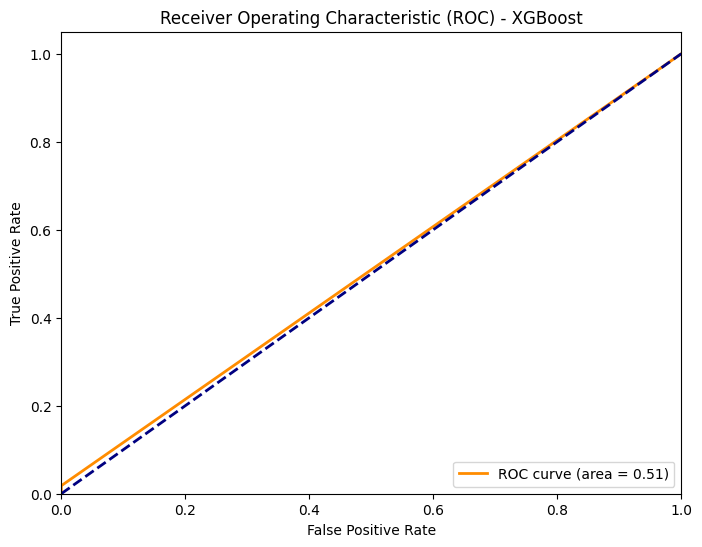

In [ ]:
y_pred_probs = model.predict(X_test_scaled)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plotting ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - XGBoost')
plt.legend(loc="lower right")
plt.show()

# neural network

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall, AUC

In [ ]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model on the test set
results = model.evaluate(X_test_scaled, y_test, verbose=1)
print(f"Test Loss, Test Accuracy, Test Precision, Test Recall, Test AUC: {results}")


Epoch 1/5


/Users/long/miniforge3/envs/langchain/lib/python3.9/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12354/12354 ━━━━━━━━━━━━━━━━━━━━ 8s 595us/step - accuracy: 0.9911 - auc: 0.5829 - loss: 0.0623 - precision: 0.0124 - recall: 9.1811e-04 - val_accuracy: 0.9923 - val_auc: 0.7009 - val_loss: 0.0428 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
12354/12354 ━━━━━━━━━━━━━━━━━━━━ 7s 561us/step - accuracy: 0.9926 - auc: 0.6570 - loss: 0.0440 - precision: 0.2913 - recall: 1.1771e-04 - val_accuracy: 0.9923 - val_auc: 0.7171 - val_loss: 0.0426 - val_precision: 1.0000 - val_recall: 0.0013
Epoch 3/5
12354/12354 ━━━━━━━━━━━━━━━━━━━━ 7s 554us/step - accuracy: 0.9928 - auc: 0.6750 - loss: 0.0420 - precision: 0.2025 - recall: 7.6726e-05 - val_accuracy: 0.9923 - val_auc: 0.7084 - val_loss: 0.0424 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
 2669/12354 ━━━━━━━━━━━━━━━━━━━━ 4s 471us/step - accuracy: 0.9918 - auc: 0.6783 - loss: 0.0450 - precision: 0.0000e+00 - recall: 0.0000e+00

8020/8020 ━━━━━━━━━━━━━━━━━━━━ 2s 274us/step


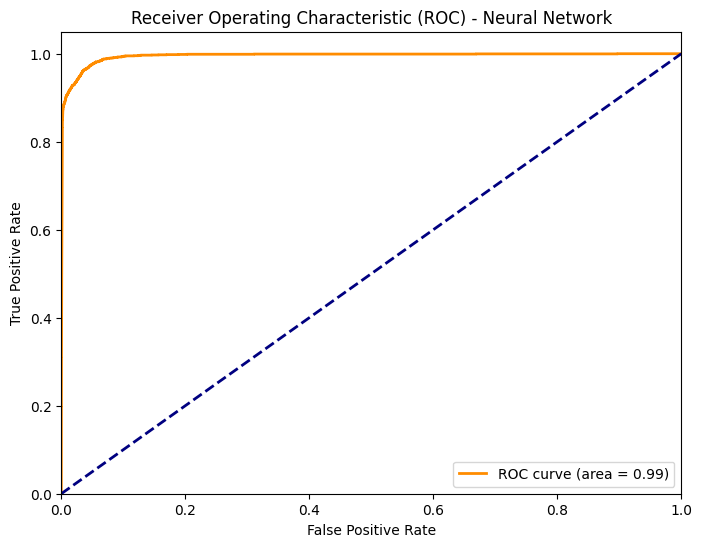

In [ ]:
y_pred_probs = model.predict(X_test_scaled)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plotting ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Neural Network')
plt.legend(loc="lower right")
plt.show()